In [9]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
pip install lifelines


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 8.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 16.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4032 sha256=580338c682478042dd1739eb9c9801a71886bb0092142fd399bc2d29bd303788
  Stored in directory: /home/jovyan/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
Note: you may need to restart the kernel to use updated packages.


In [8]:
!pip install lifelines


#### v nasledujúcej časti sa pozrieme na dáta, na chýbajúce hodnoty, na nejaké štatistiky. Jednoducho povedané urobíme takú exploračnú analýzu 

In [20]:
data = pd.read_csv("Breast Cancer METABRIC.csv")

In [21]:
data.head()

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,ER Status,Neoplasm Histologic Grade,HER2 status measured by SNP6,HER2 Status,Tumor Other Histologic Subtype,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Primary Tumor Laterality,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Oncotree Code,Overall Survival (Months),Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,75.65,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,No,claudin-low,1.0,Positve,Positive,3.0,Neutral,Negative,Ductal/NST,Yes,Post,4ER+,Right,10.0,NaN,6.044,IDC,140.500000,Living,Negative,Yes,138.65,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43.19,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,Positive,3.0,Neutral,Negative,Ductal/NST,Yes,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,Living,Positive,Yes,83.52,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,48.87,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,Positive,2.0,Neutral,Negative,Ductal/NST,Yes,Pre,3,Right,1.0,2.0,4.030,IDC,163.700000,Deceased,Positive,No,151.28,Recurred,Female,NaN,15.0,2.0,Died of Disease
3,MB-0006,47.68,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,Positive,2.0,Neutral,Negative,Mixed,Yes,Pre,9,Right,3.0,1.0,4.050,MDLC,164.933333,Living,Positive,Yes,162.76,Not Recurred,Female,NaN,25.0,2.0,Living
4,MB-0008,76.97,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,Positive,3.0,Neutral,Negative,Mixed,Yes,Post,9,Right,8.0,2.0,6.080,MDLC,41.366667,Deceased,Positive,Yes,18.55,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Patient ID                      2509 non-null   object 
 1   Age at Diagnosis                2498 non-null   float64
 2   Type of Breast Surgery          1955 non-null   object 
 3   Cancer Type                     2509 non-null   object 
 4   Cancer Type Detailed            2509 non-null   object 
 5   Cellularity                     1917 non-null   object 
 6   Chemotherapy                    1980 non-null   object 
 7   Pam50 + Claudin-low subtype     1980 non-null   object 
 8   Cohort                          2498 non-null   float64
 9   ER status measured by IHC       2426 non-null   object 
 10  ER Status                       2469 non-null   object 
 11  Neoplasm Histologic Grade       2388 non-null   float64
 12  HER2 status measured by SNP6    19

#### Ako vidíme, dáta obsahújú pomerne veľa chýbajúcich hodnôt čo sa budeme snažiť vyriešiť a doplniť ich vhodnou metódou. Na spodnej vizualizácii potom môžeme vidieť, v ktorých atribútuch je chýbajúcich hodnôt najviac a pre porovnanie aj 5 atribútov, ktoré neobsahujú žiadne chýbajúce hodnoty.

In [41]:
print(data.isnull().sum())


Patient ID                        0
Age at Diagnosis                  0
Type of Breast Surgery            0
Cancer Type                       0
Cancer Type Detailed              0
Cellularity                       0
Chemotherapy                      0
Pam50 + Claudin-low subtype       0
Cohort                            0
ER status measured by IHC         0
ER Status                         0
Neoplasm Histologic Grade         0
HER2 status measured by SNP6      0
HER2 Status                       0
Tumor Other Histologic Subtype    0
Hormone Therapy                   0
Inferred Menopausal State         0
Integrative Cluster               0
Primary Tumor Laterality          0
Lymph nodes examined positive     0
Mutation Count                    0
Nottingham prognostic index       0
Oncotree Code                     0
Overall Survival (Months)         0
Overall Survival Status           0
PR Status                         0
Radio Therapy                     0
Relapse Free Status (Months)

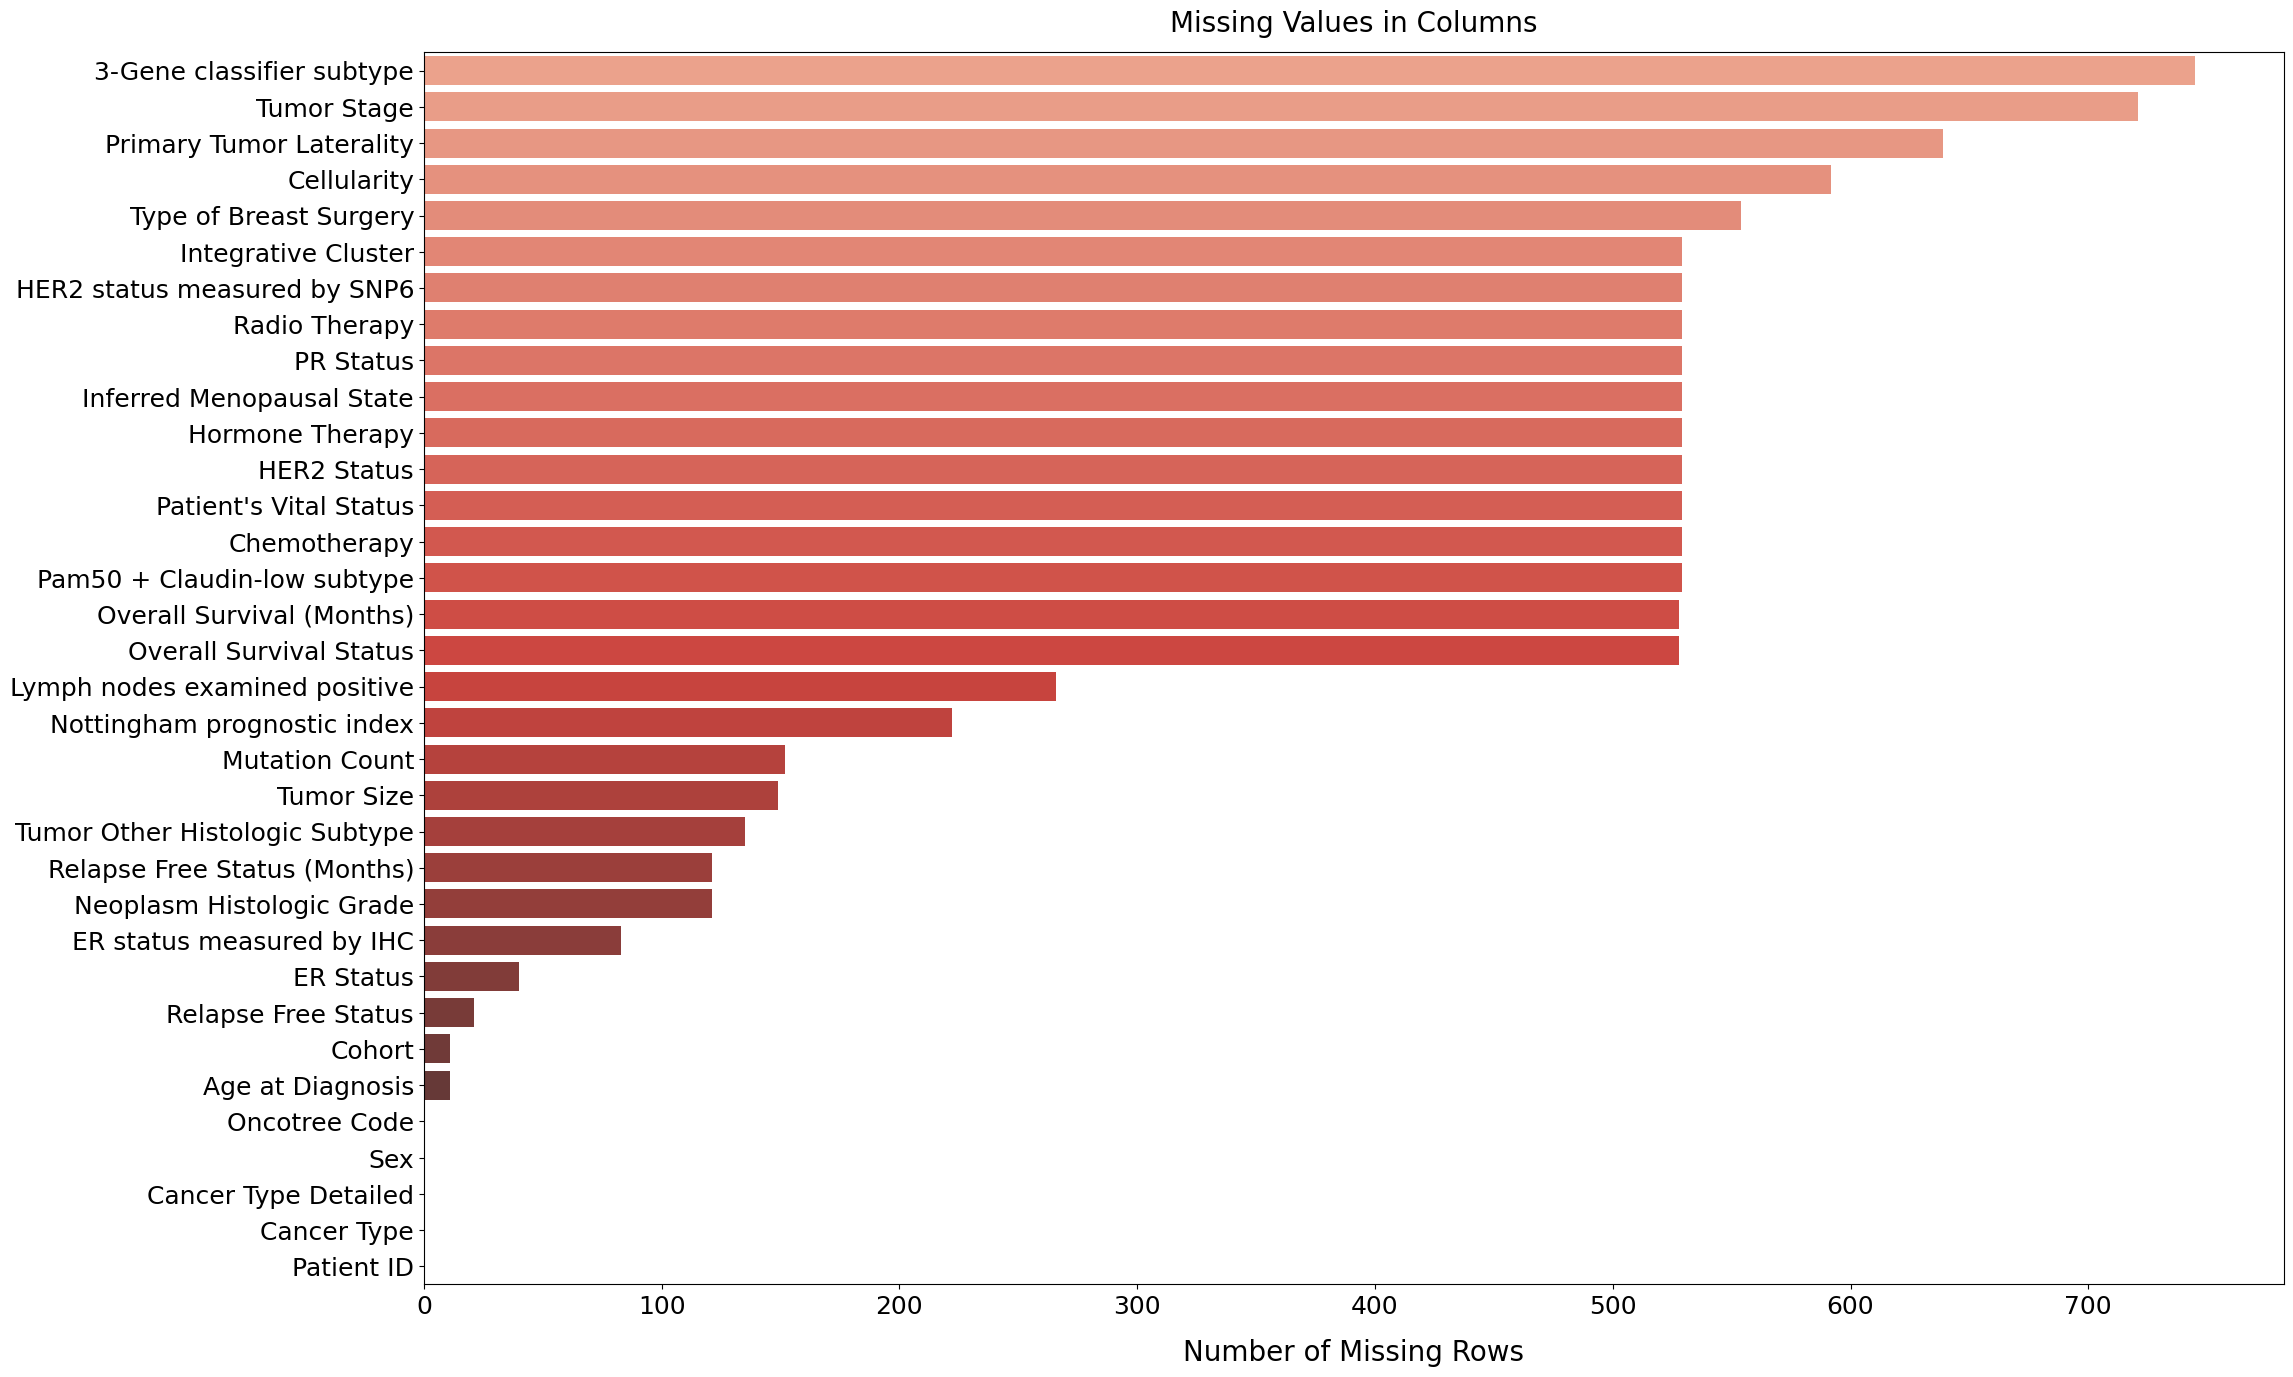

In [24]:
fig = plt.figure(figsize=(24, 16))

sns.barplot(x=data.isnull().sum().sort_values(ascending=False).values,
            y=data.isnull().sum().sort_values(ascending=False).index,
            palette='Reds_d')

plt.xlabel('Number of Missing Rows', size=20, labelpad=15)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Missing Values in Columns', size=20, pad=15)

plt.show()

In [25]:
print(f'METABRIC Dataset Shape: {data.shape}')


METABRIC Dataset Shape: (2509, 34)


## Dopnenie chýbajúcich hodnôt
#### Ako môžeme vidieť, súbor údajov obsahuje viacero chýbajúcich hodnôt vo viacerých atribútoch preto v nasledujúcej časti tieto hodnoty doplníme 

In [34]:
# V atribúte Relapse Free Status (Status bez relapsu) zoskúpime údaje podľa atribútu Cancer Type Detailed a všetky chýbajúce hodnoty tohto atribútu potom nahradíme najčastejšie
# sa vyskytujúcou hodnotou v tejto skupine 
data['Relapse Free Status'] = data.groupby(['Cancer Type Detailed'])['Relapse Free Status'].apply(lambda x: x.fillna(mode(x)[0][0]))


In [35]:
# podobným princípom doplníme aj chýbajúce hodnoty atribútu Overall Survival Status (Celkový stav prežitia) 
data['Overall Survival Status'] = data.groupby(['Cancer Type Detailed', 'Relapse Free Status'])['Overall Survival Status'].apply(lambda x: x.fillna(mode(x)[0][0]))


In [36]:
#chýbajúce hodnoty atribútov Relapse Free Status (Months) a Overal Status (Months) doplníme zase priemernou hodnotou v rámci skupiny (podľa ktorej sú zgrupnuté) 
data['Relapse Free Status (Months)'] = data.groupby(['Cancer Type Detailed', 'Relapse Free Status'])['Relapse Free Status (Months)'].apply(lambda x: x.fillna(x.mean()))
data['Overall Survival (Months)'] = data.groupby(['Cancer Type Detailed', 'Overall Survival Status'])['Overall Survival (Months)'].apply(lambda x: x.fillna(x.mean()))


In [37]:
# v nasledujúcej časti doplníme chýbajúce hodnoty atribútov ER (estrogénová receptor), PR (progesterónový receptor) a HER2 (Ľudský epidermálny rastový faktor receptorov 2)
# Doplníme ich najčastejšie sa vyskytujúcimi hodnotami v rámci atribútu alebo v rámci skupiny
data['ER status measured by IHC'] = data['ER status measured by IHC'].fillna(mode(data['ER status measured by IHC'])[0][0])
data['ER Status'] = data.groupby(['ER status measured by IHC'])['ER Status'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['HER2 status measured by SNP6'] = data['HER2 status measured by SNP6'].fillna(mode(data['HER2 status measured by SNP6'])[0][0])
data['HER2 Status'] = data.groupby(['HER2 status measured by SNP6'])['HER2 Status'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['PR Status'] = data.groupby(['Cancer Type Detailed'])['PR Status'].apply(lambda x: x.fillna(mode(x)[0][0]))


In [38]:
#podobným princípom doplníme aj zvyšné chýbajúce hodnoty v datasete
# Chemotherapy, Hormone Therapy, Radio Therapy columns
data['Chemotherapy'] = data.groupby(['Cancer Type Detailed'])['Chemotherapy'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['Hormone Therapy'] = data.groupby(['Cancer Type Detailed'])['Hormone Therapy'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['Radio Therapy'] = data.groupby(['Cancer Type Detailed'])['Radio Therapy'].apply(lambda x: x.fillna(mode(x)[0][0]))

# Other columns
data['Age at Diagnosis'] = data.groupby(['Cancer Type Detailed'])['Age at Diagnosis'].apply(lambda x: x.fillna(x.mean()))
data['Cohort'] = data.groupby(['Cancer Type Detailed'])['Cohort'].apply(lambda x: x.fillna(x.median()))
data['Cellularity'] = data.groupby(['Cancer Type Detailed'])['Cellularity'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['Tumor Stage'] = data.groupby(['Cancer Type Detailed', 'Cellularity'])['Tumor Stage'].apply(lambda x: x.fillna(x.median()))
data['Tumor Stage'] = data.groupby(['Cancer Type Detailed'])['Tumor Stage'].apply(lambda x: x.fillna(x.median()))
data['Tumor Size'] = data.groupby(['Cancer Type Detailed', 'Tumor Stage'])['Tumor Size'].apply(lambda x: x.fillna(x.median()))
data['Tumor Size'] = data.groupby(['Cancer Type Detailed'])['Tumor Size'].apply(lambda x: x.fillna(x.median()))
data['Tumor Size'] = data['Tumor Size'].fillna(mode(data['Tumor Size'])[0][0])
data['Neoplasm Histologic Grade'] = data.groupby(['Cancer Type Detailed'])['Neoplasm Histologic Grade'].apply(lambda x: x.fillna(x.mode()))
data['Neoplasm Histologic Grade'] = data['Neoplasm Histologic Grade'].fillna(mode(data['Neoplasm Histologic Grade'])[0][0])
data['Primary Tumor Laterality'] = data.groupby(['Cancer Type Detailed'])['Primary Tumor Laterality'].apply(lambda x: x.fillna(x.mode()))
data['Tumor Other Histologic Subtype'] = data.groupby(['Cancer Type Detailed'])['Tumor Other Histologic Subtype'].apply(lambda x: x.fillna(x.mode()))
data['Tumor Other Histologic Subtype'] = data['Tumor Other Histologic Subtype'].fillna('Ductal/NST')
data['Mutation Count'] = data.groupby(['Cancer Type Detailed'])['Mutation Count'].apply(lambda x: x.fillna(x.mode()))
data['Mutation Count'] = data['Mutation Count'].fillna(mode(data['Mutation Count'])[0][0])
data['Nottingham prognostic index'] = data.groupby(['Tumor Size'])['Nottingham prognostic index'].apply(lambda x: x.fillna(x.median()))
data['Nottingham prognostic index'] = data['Nottingham prognostic index'].fillna(data['Nottingham prognostic index'].median())
data['Lymph nodes examined positive'] = data.groupby(['Cancer Type Detailed'])['Lymph nodes examined positive'].apply(lambda x: x.fillna(x.mode()))
data['Lymph nodes examined positive'] = data['Lymph nodes examined positive'].fillna(mode(data['Lymph nodes examined positive'])[0][0])
data['Inferred Menopausal State'] = data['Inferred Menopausal State'].fillna(mode(data['Inferred Menopausal State'])[0][0])
data['Pam50 + Claudin-low subtype'] = data.groupby(['Cancer Type Detailed'])['Pam50 + Claudin-low subtype'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['Integrative Cluster'] = data.groupby(['Cancer Type Detailed'])['Cellularity'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['Type of Breast Surgery'] = data.groupby(['Cancer Type Detailed'])['Type of Breast Surgery'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['Primary Tumor Laterality'] = data.groupby(['Cancer Type Detailed'])['Primary Tumor Laterality'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['3-Gene classifier subtype'] = data.groupby(['Cancer Type Detailed'])['3-Gene classifier subtype'].apply(lambda x: x.fillna(mode(x)[0][0]))



In [40]:
#Zvysne chybajuce hodnoty odstranime 
data = data.dropna()


# Vizualizácie

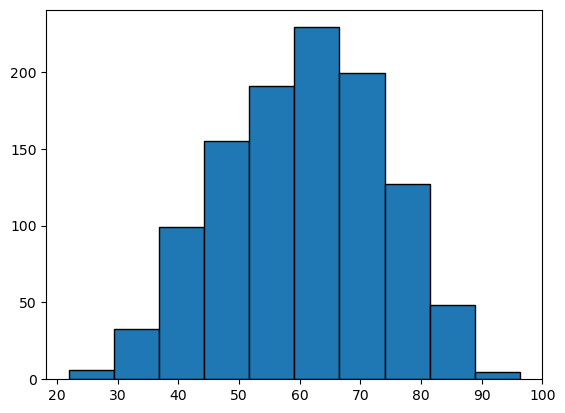

In [115]:
# ako vidíme, najčastejšie sa rakovina prsníka vyskytuje u žien v strednom veku, naopak menej častou je u žien, ktoré majú menej ako 20 alebo 30 rokov 
plt.hist(data['Age at Diagnosis'], bins=10, edgecolor='black')
plt.show()20

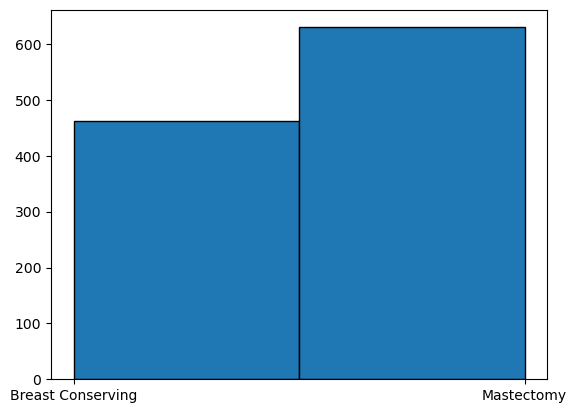

In [116]:
# Vidíme, že u väčšiny žien bola vykonané masterektómia teda chirurgické odstránenie pesníka, môže to naznačovať, že mali pokročilé štúdium rakoviny, ktoré si vyžadovalo agresívnejšiu liečbu
plt.hist(data['Type of Breast Surgery'], bins=2, edgecolor='black')
plt.show()

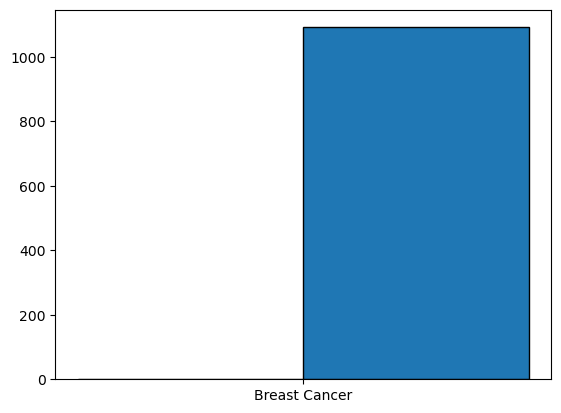

In [117]:
# kedže všetky pacientky majú rakovinu prsníka, a teda tento atribút má všetky hodnoty rovnaké, neskôr ho odstránime
plt.hist(data['Cancer Type'], bins=2, edgecolor='black')
plt.show()

### "Breast Invasive Ductal Carcinoma" (invazívny duktálny karcinóm prsníka) je najčastejší typ rakoviny prsníka. Predstavuje asi 70-80% všetkých prípadov rakoviny prsníka. Je to agresívny typ rakoviny, ktorý sa vyvíja v mliečnych kanálikoch prsníka a môže sa šíriť do okolitého tkaniva. Naopak "Breast Angiosarcoma" (angiosarkóm prsníka) a "Metaplastic Breast Cancer" (metaplastický rakovina prsníka) sú oveľa menej bežné typy rakoviny prsníka v porovnaní s invazívnym duktálnym karcinómom prsníka. Tieto informácie môžu podľa vypovedať aj o kvalite samotného súboru odajov, lebo naozaj odráža skutočné rozdelenie typov rakoviny prsníka

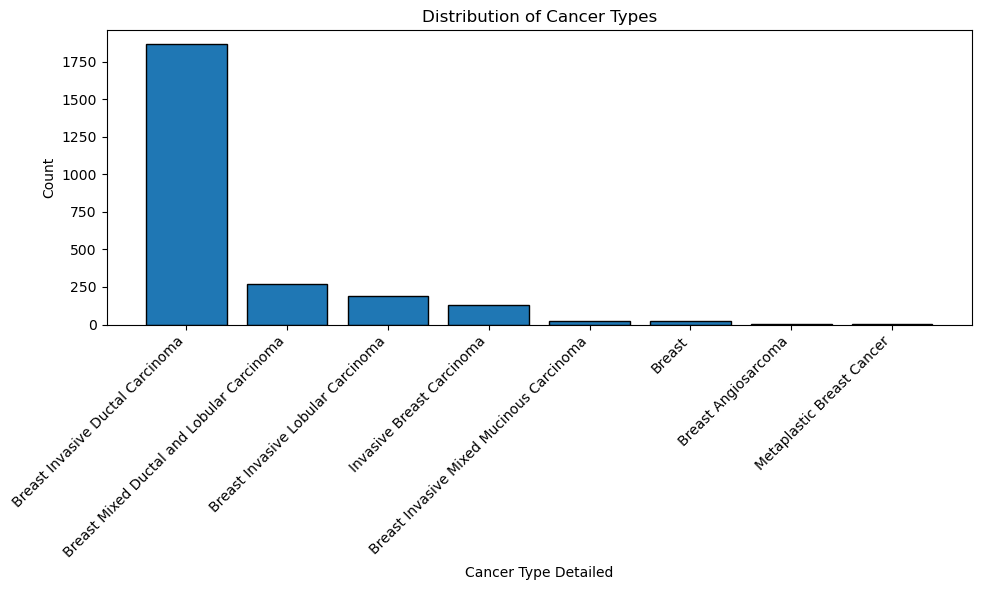

In [31]:
import matplotlib.pyplot as plt

# Spočítanie počtu výskytov jednotlivých typov rakoviny
cancer_type_counts = data['Cancer Type Detailed'].value_counts()

# Vykreslenie barového grafu
plt.figure(figsize=(10, 6))
plt.bar(cancer_type_counts.index, cancer_type_counts.values, edgecolor='black')

# Nastavenie názvov osí a titulu grafu
plt.xlabel('Cancer Type Detailed')
plt.ylabel('Count')
plt.title('Distribution of Cancer Types')

# Otočenie popisov na osi x, aby boli čitateľné
plt.xticks(rotation=45, ha='right')

# Zobrazenie grafu
plt.tight_layout()
plt.show()


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Patient ID                      2509 non-null   object 
 1   Age at Diagnosis                2509 non-null   float64
 2   Type of Breast Surgery          2415 non-null   object 
 3   Cancer Type                     2509 non-null   object 
 4   Cancer Type Detailed            2509 non-null   object 
 5   Cellularity                     2413 non-null   object 
 6   Chemotherapy                    2418 non-null   object 
 7   Pam50 + Claudin-low subtype     2418 non-null   object 
 8   Cohort                          2509 non-null   float64
 9   ER status measured by IHC       2509 non-null   object 
 10  ER Status                       2509 non-null   object 
 11  Neoplasm Histologic Grade       2509 non-null   float64
 12  HER2 status measured by SNP6    25

## V nasledujúcej časti je kód, ktorým zabezpečíme to, aby naše dáta boli numerické. Coxová regresia pracuje iba s numerickými dátami a vyžaduje kódovanie kategorických atribútov (toto si musím bližšie naštudovať). Tento proces som najprv robila manuálne, kde som si v rámci atribútov vypísala unikátne hodnoty a tie potom nahradila číslami, ale našla som tento kód, ktorý to robí jednoducho a efektívne tak som sa ho rozhodla použiť


In [42]:
object_cols = ['Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed', 'Cellularity',
               'Chemotherapy', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'ER status measured by IHC',
               'ER Status', 'HER2 status measured by SNP6', 'HER2 Status', 'Tumor Other Histologic Subtype',
               'Hormone Therapy', 'Inferred Menopausal State', 'Integrative Cluster', 'Primary Tumor Laterality',
               'Oncotree Code', 'PR Status', 'Radio Therapy', 'Sex', '3-Gene classifier subtype']

for col in object_cols:
    data[col] = np.uint8(LabelEncoder().fit_transform(data[col]))
    
data['Overall Survival Status'] = np.uint8(data['Overall Survival Status'].map({'Living': 0, 'Deceased': 1}))
data['Relapse Free Status'] = np.uint8(data['Relapse Free Status'].map({'Not Recurred': 0, 'Recurred': 1}))

In [43]:
# ako vidíme, dáta už obsahujú len numerické hodnoty s tým, že atribút Patien ID aj tak neskôr odstránime
data.head()

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,ER Status,Neoplasm Histologic Grade,HER2 status measured by SNP6,HER2 Status,Tumor Other Histologic Subtype,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Primary Tumor Laterality,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Oncotree Code,Overall Survival (Months),Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,75.65,1,0,2,0,0,6,1.0,1,1,3.0,2,0,0,1,0,0,1,10.0,5.0,6.044,2,140.500000,0,0,1,138.65,0,0,2,22.0,2.0,Living
1,MB-0002,43.19,0,0,2,0,0,2,1.0,1,1,3.0,2,0,0,1,1,0,1,0.0,2.0,4.020,2,84.633333,0,1,1,83.52,0,0,0,10.0,1.0,Living
3,MB-0006,47.68,1,0,5,2,1,3,1.0,1,1,2.0,2,0,4,1,1,2,1,3.0,1.0,4.050,6,164.933333,0,1,1,162.76,0,0,1,25.0,2.0,Living
4,MB-0008,76.97,1,0,5,0,1,3,1.0,1,1,3.0,2,0,4,1,0,0,1,8.0,2.0,6.080,6,41.366667,1,1,1,18.55,1,0,0,40.0,2.0,Died of Disease
5,MB-0010,78.77,1,0,2,2,0,3,1.0,1,1,3.0,2,0,0,1,0,2,0,0.0,4.0,4.062,2,7.800000,1,1,1,2.89,1,0,0,31.0,4.0,Died of Disease


In [45]:
# V Cox regresii je potrebné určiť dva dôležité atribúty. Jeden, ktorý bude reprezentovať čas, ktorý uplynul od nejakého začiatočného bodu (ako napríklad diagnostikovanie rakoviny) 
# a druhý atribút, ktorý bude reprezentovať udalosť, čiže to či daná udalosť v našom prípade smrť pacienta nastala (1) alebo nie (0)
# ja som sa rozhodla si tieto stlpce premenovat aby som v tom mala jasnejsie 
data.rename(columns={
    "Patient's Vital Status": "event",
    "Overall Survival (Months)": "time"
}, inplace=True)


In [46]:
# Atribút event nadobúda tri hodnoty, ktoré nahradíme 0 alebo 1 podľa toho či pacient žije alebo zomrel (teraz nebudem riešiť či zomrel kvôli rakovine alebo z iného dôvodu)
# Pre zjednodušenie 

In [48]:
# Replace values
data['event'] = data['event'].replace({
    'Living': 1,
    'Died of Disease': 0,
    'Died of Other Causes': 0
})

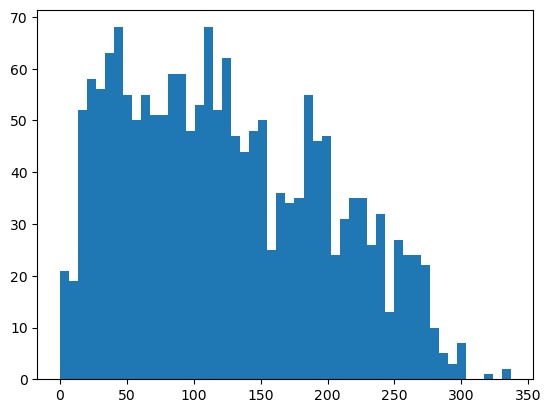

In [49]:
T = data["time"]
E = data["event"]
plt.hist(T, bins = 50)
plt.show()

# Kaplan - Meierova krivka 
### je grafická metóda používaná na vizualizáciu časovej distribúcie prežitia v populácii, najmä pri štúdiách doby prežitia v medicíne a biológii. Je úzko spojená s Coxovou regresiou a je často používaná na analýzu a porovnávanie doby prežitia medzi rôznymi skupinami pacientov.
 

##### Na základe tohto grafu vidíme a krivky vidíme ako sa mení pravdepodobnosť prežitia v časovom horizonte. Postupom času sa pravdepodobnosť prežitia pacientov s rakovinou prsníka znižuje 

<AxesSubplot:xlabel='timeline'>

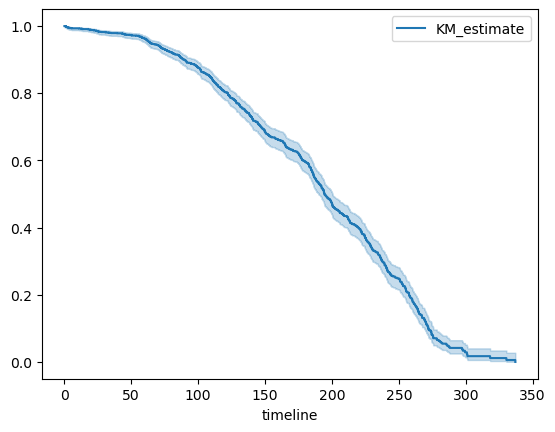

In [50]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot_survival_function()

In [ ]:
# Pomocou metódy .survival_function_.plot() môžeme vygenerovať rovnaký graf bez 95% intervalu spoľahlivosti .


Text(0.5, 1.0, 'Funkcia prežitia')

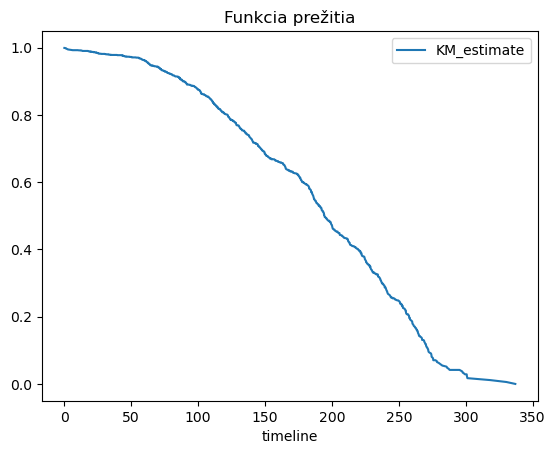

In [51]:
kmf.survival_function_.plot() 
plt.title('Funkcia prežitia')

In [ ]:
# Môžeme tiež vykresliť krivku zlyhania. Je to pravý opak prežitia, tj pravdepodobnosti zlyhania/úmrtia v priebehu času.

<AxesSubplot:xlabel='timeline'>

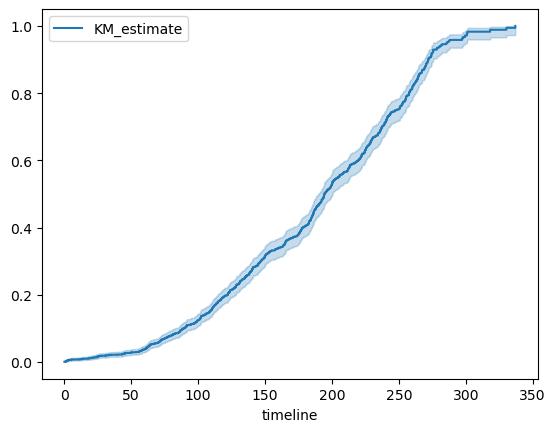

In [52]:
kmf.plot_cumulative_density()

#### Ďalším krokom je odhad strednej doby prežitia a 95% intervaly spoľahlivosti. V našom prípade je stredná doba prežitia 198 dní, čo znamená, že 50% vzorky žije 198 dní a 50% v tomto čase umrie. Spodná hranica je 190 dní a horná je 207

In [53]:
from lifelines.utils import median_survival_times
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

194.5333333
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   189.9              200.333333


# Cox regresia 
#### je štatistická metóda používaná na analýzu doby prežitia alebo časových dát. Je často používaná v medicíne a biológii na štúdium doby prežitia pacientov s určitými ochoreniami, ako je rakovina.
##### Na základe analýzy článkov, ktoré sa zaoberali touto tématikou som sa rozhodla na výber atribútov vhodných atribútov do modelu log-rank štatistický test a potom aj metódu L1 Regularization (Lasso Regression)

##### Zjednodučene najpr sa definujú stĺpce, ktoré obsahujú infomráciu o čase (time) a udalosti (event). Tieto stĺpce nerieši. Prechádza všetky ostatné a pre každý atribút sa vykonáva log-rank test. Ak je p-hodnota (pravdepodobnosť) testu nižšia ako stanovená prahová hodnota (v tomto prípade 0.05 lebo spoľahlivosť je 95 percent), atribút sa považuje za významný a pridá sa do zoznamu relevantných atribútov

In [54]:
# Definovanie stĺpcov pre čas a udalosť
from lifelines.statistics import logrank_test
duration_col = 'time'
event_col = 'event'

# Funkcia na vykonanie log-rank testu pre jednotlivé atribúty
def perform_logrank_test(df, attribute, time_col, event_col):
    categories = df[attribute].unique()
    if len(categories) != 2:
        raise ValueError(f"Atribút {attribute} nemá presne 2 kategórie, má {len(categories)}.")
    
    cat1, cat2 = categories
    df_cat1 = df[df[attribute] == cat1]
    df_cat2 = df[df[attribute] == cat2]

    result = logrank_test(df_cat1[time_col], df_cat2[time_col], 
                          event_observed_A=df_cat1[event_col], 
                          event_observed_B=df_cat2[event_col])
    
    return result

# Iterácia cez všetky atribúty a vykonanie log-rank testu
significant_attributes = []
p_value_threshold = 0.05

for attribute in data.columns:
    if attribute not in [duration_col, event_col]:
        try:
            result = perform_logrank_test(data, attribute, duration_col, event_col)
            p_value = result.p_value
            if p_value < p_value_threshold:
                significant_attributes.append((attribute, p_value))
        except ValueError as e:
            print(e)

# Výpis relevantných atribútov
print("Relevantné atribúty podľa log-rank testu:")
for attribute, p_value in significant_attributes:
    print(f"Atribút: {attribute}, p-hodnota: {p_value}")

Atribút Patient ID nemá presne 2 kategórie, má 1788.
Atribút Age at Diagnosis nemá presne 2 kategórie, má 1499.
Atribút Cancer Type Detailed nemá presne 2 kategórie, má 8.
Atribút Cellularity nemá presne 2 kategórie, má 3.
Atribút Pam50 + Claudin-low subtype nemá presne 2 kategórie, má 7.
Atribút Cohort nemá presne 2 kategórie, má 5.
Atribút Neoplasm Histologic Grade nemá presne 2 kategórie, má 3.
Atribút HER2 status measured by SNP6 nemá presne 2 kategórie, má 4.
Atribút Tumor Other Histologic Subtype nemá presne 2 kategórie, má 8.
Atribút Integrative Cluster nemá presne 2 kategórie, má 3.
Atribút Lymph nodes examined positive nemá presne 2 kategórie, má 29.
Atribút Mutation Count nemá presne 2 kategórie, má 29.
Atribút Nottingham prognostic index nemá presne 2 kategórie, má 310.
Atribút Oncotree Code nemá presne 2 kategórie, má 8.
Atribút Relapse Free Status (Months) nemá presne 2 kategórie, má 1569.
Atribút Sex nemá presne 2 kategórie, má 1.
Atribút 3-Gene classifier subtype nemá pr

##### L1 Regularizácia, známa aj ako Lasso (Least Absolute Shrinkage and Selection Operator), je technika používaná v regresnej analýze na redukciu prebytočných atribútov prostredníctvom penalizácie ich koeficientov na nulu.

In [56]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

data.drop('Patient ID', axis=1, inplace=True)

# Predpripravenie dát
X = data.drop(['time', 'event'], axis=1)  # Atribúty bez času a udalosti
y = data['time']  # Cieľový atribút - čas

# Rozdelenie dát na trénovacie a testovacie sady
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vytvorenie a trénovanie modelu Lasso Regression s krížovou validáciou (CV)
lasso_cv = LassoCV(cv=5)  # cv=5 znamená použitie 5-fold krížovej validácie
lasso_cv.fit(X_train, y_train)

# Získanie vybraných atribútov (s nenulovými koeficientmi)
selected_attributes = X.columns[lasso_cv.coef_ != 0]

# Výpis vybraných atribútov
print("Vybrané atribúty:")
for attribute in selected_attributes:
    print(attribute)


Vybrané atribúty:
Age at Diagnosis
Lymph nodes examined positive
Relapse Free Status (Months)
Relapse Free Status
Tumor Size


#### V nasledujúcej časti už priamo naprogramujem coxovú regresiu a budem sa snažiť interpretovať jej výsledky. Zatiaľ sa zameriam na interpretovanie koeficientu.

In [80]:
import pandas as pd
from lifelines import CoxPHFitter

# Predpokladaný dátový rámec
# data = pd.read_csv('path_to_your_data.csv')

# Zoznam relevantných atribútov
relevant_attributes = [
    'Type of Breast Surgery',
    'Cancer Type',
    'Chemotherapy', 
    'ER Status',
    'HER2 Status', 
    'Hormone Therapy', 
    'Primary Tumor Laterality', 
    'Overall Survival Status',
    'PR Status',
    'Radio Therapy', 
    'Relapse Free Status'
]

# Kontrola, či všetky relevantné atribúty sú v dátovom rámci
for attribute in relevant_attributes:
    if attribute not in data.columns:
        raise ValueError(f"Atribút {attribute} nie je v dátovom rámci.")

# Príprava dát: Kategorické premenné prevedieme na numerické (One-Hot Encoding)
data_encoded = pd.get_dummies(data[relevant_attributes], drop_first=True)

# Pridáme stĺpce pre čas a udalosť do dátového rámca
data_encoded[duration_col] = data[duration_col]
data_encoded[event_col] = data[event_col]

# Definovanie Coxovho modelu
cph = CoxPHFitter()

# Fitovanie modelu na dáta
cph.fit(data_encoded, duration_col=duration_col, event_col=event_col)

# Výsledky modelu
cph.print_summary()

# Predikcie (napr. medián prežitia pre jednotlivé záznamy)
predictions = cph.predict_median(data_encoded)
print(predictions.head())

<lifelines.CoxPHFitter: fitted with 1788 total observations, 1017 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1788
number of events observed = 771
   partial log-likelihood = -4303.69
         time fit was run = 2024-06-06 15:10:39 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
Type of Breast Surgery    -0.01       0.99       0.10            -0.20             0.18                 0.82                 1.19
Cancer Type                1.73       5.66       0.72             0.32             3.15                 1.37                23.33
Chemotherapy               0.30       1.35       0.10             0.09             0.50                 1.10                 1.65
ER Status                 -0.08       0.93       0.12            -0.31             0.16                 0.73                 1.17
HER2 Status                0.13       1.14       0.12            -0.11             0.36                 0.90                 1.44
Hormone Therapy            0.60       1.83       0.08             0.44             0.77                 1.56                 2.15
Primary Tumor Laterality   0.09       1.09       0.07            -0.06             0.23                 0.94                 1.26
Overall Survival Status  -19.54       0.00     890.02         -1763.96          1724.87                 0.00                  inf
PR Status                 -0.01       0.99       0.09            -0.19             0.16                 0.83                 1.18
Radio Therapy              0.16       1.18       0.10            -0.04             0.37                 0.96                 1.44
Relapse Free Status       -0.60       0.55       0.12            -0.83            -0.36                 0.43                 0.70

                           cmp to     z      p   -log2(p)
covariate                                                
Type of Breast Surgery       0.00 -0.15   0.88       0.18
Cancer Type                  0.00  2.40   0.02       5.92
Chemotherapy                 0.00  2.86 <0.005       7.87
ER Status                    0.00 -0.63   0.53       0.92
HER2 Status                  0.00  1.06   0.29       1.80
Hormone Therapy              0.00  7.28 <0.005      41.49
Primary Tumor Laterality     0.00  1.18   0.24       2.06
Overall Survival Status      0.00 -0.02   0.98       0.03
PR Status                    0.00 -0.17   0.87       0.20
Radio Therapy                0.00  1.56   0.12       3.07
Relapse Free Status          0.00 -4.99 <0.005      20.67
---
Concordance = 0.78
Partial AIC = 8629.39
log-likelihood ratio test = 805.92 on 11 df
-log2(p) of ll-ratio test = 548.10

0    137.666667
1    137.666667
3    121.966667
4           inf
5           inf
Name: 0.5, dtype: float64


In [66]:
#plt.subplots(figsize = (10, 6))
#cph.plot()

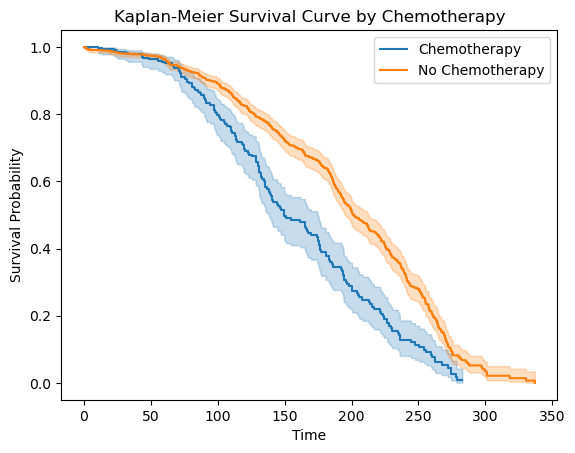

In [72]:
#Skusim sa pozriet na porovnanie chemoterapie, hormonalnej a radio terapie 
# Pri chemoterapii vysiel koeficient 0.30 čo môžeme interpretovať tak, že pacienti, ktorí dostali chemoterapiu majú o 30% vyššiu šancu, že udalosť nastane (smrť)
# v skutku by sa to mohlo javiť ako desivý fakt, ale možno ide o to, že jednoducho už keď potrebuje pacient chemoteriu asi to nie je počiatočné ale už agresívnejšie štádium
# Je tu aj vizualizacia, kde vidíme, že pacienti, ktorí nemusia brať chemoterapiu sú natom trošku lepšie 
#cph.plot_partial_effects_on_outcome(covariates = 'Chemotherapy', values = [0,1], cmap = 'coolwarm')
from lifelines import KaplanMeierFitter

# Inicializácia Kaplan-Meierovho modelu
kmf = KaplanMeierFitter()

# Rozdelenie dát na skupiny s a bez chemoterapie
chemo_group = data[data['Chemotherapy'] == 1]
no_chemo_group = data[data['Chemotherapy'] == 0]

# Fitovanie modelu pre každú skupinu
kmf.fit(chemo_group['time'], event_observed=chemo_group['event'], label='Chemotherapy')
ax = kmf.plot()

kmf.fit(no_chemo_group['time'], event_observed=no_chemo_group['event'], label='No Chemotherapy')
kmf.plot(ax=ax)

# Označenie osí a titulok
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Survival Curve by Chemotherapy')

# Zobrazenie grafu
plt.show()


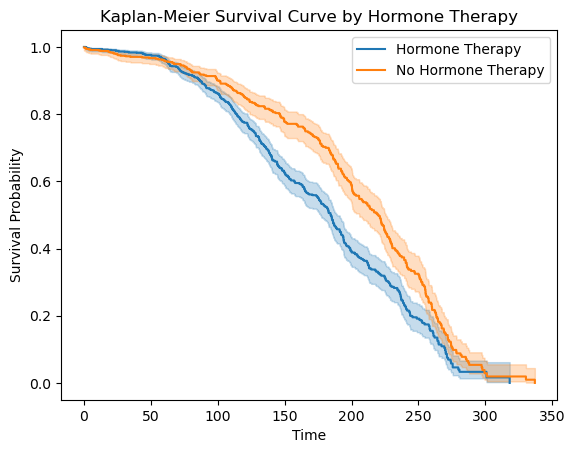

In [73]:
# Coxova regresia modeluje logaritmus rizika preto môžeme koeficient 0,60 interpretovať ako zmenu v percentách. V tomto prípade je koeficient 0,60 stredne vysoká zmena.
# Konkrétne, koeficient 0,60 naznačuje, že pacienti, ktorí podstupujú Hormone Therapy, majú o 60% vyššiu pravdepodobnosť udalosti (v tomto prípade smrti),
# v porovnaní s pacientmi, ktorí ju nepodstupujú. 
# Inicializácia Kaplan-Meierovho modelu
kmf = KaplanMeierFitter()

# Rozdelenie dát na skupiny s a bez Hormone Therapy
hormone_therapy_group = data[data['Hormone Therapy'] == 1]
no_hormone_therapy_group = data[data['Hormone Therapy'] == 0]

# Fitovanie modelu pre každú skupinu
kmf.fit(hormone_therapy_group['time'], event_observed=hormone_therapy_group['event'], label='Hormone Therapy')
ax = kmf.plot()

kmf.fit(no_hormone_therapy_group['time'], event_observed=no_hormone_therapy_group['event'], label='No Hormone Therapy')
kmf.plot(ax=ax)

# Označenie osí a titulok
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Survival Curve by Hormone Therapy')

# Zobrazenie grafu
plt.show()


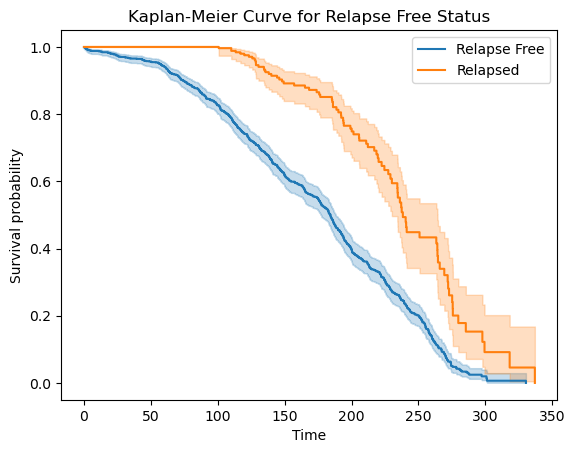

In [74]:
# v pripade atributu Relapse Free Status (0 alebo 1) dosiahol koeficient hodnotu -0.60
# TOto mi napriklad vobec nesedu lebo by som predpokladala, ze ked sa pacientovi vratila alebo vracia rakovina tak ma vacsiu sancu na smrt ale graf tvrdi opak ...
# Vytvorenie inštancie KaplanMeierFitter
kmf = KaplanMeierFitter()

# Rozdelenie dát podľa hodnôt atribútu "Relapse Free Status"
relapse_free = data['Relapse Free Status'] == 0
relapsed = data['Relapse Free Status'] == 1

# Príprava dát pre Kaplan-Meierovu krivku
kmf.fit(data.loc[relapse_free, 'time'], data.loc[relapse_free, 'event'], label='Relapse Free')
ax = kmf.plot()

kmf.fit(data.loc[relapsed, 'time'], data.loc[relapsed, 'event'], label='Relapsed')
kmf.plot(ax=ax)

# Označenie osí a titulok
plt.xlabel('Time')
plt.ylabel('Survival probability')
plt.title('Kaplan-Meier Curve for Relapse Free Status')

# Zobrazenie grafu
plt.show()


# Vyhodnotenie modelu
#### Tu som zatial použila len metriku C-index, ktorá sa najčastejšie spomínala aj v článkoch, ktoré som čítala. Hodnota C-indexu 0.77 je relatívne dobrý výsledok lebo C-index môže nadobúdať hodnoty od 0 po 1, pričom 1 znamený dokonalá predikcia.

In [82]:
from lifelines.utils import concordance_index

# Vyhodnotenie modelu pomocou Konkordancie
c_index = concordance_index(data_encoded[duration_col], -cph.predict_partial_hazard(data_encoded), data_encoded[event_col])
print("Konkordancia (C-index):", c_index)


Konkordancia (C-index): 0.7755147071803049


# Vizualizácie
#### Skúsila som aj nejaké vizualizovanie, že ako sú natom skutočné a predikované hodnoty, no tie grafy sú nič moc. Možno najlepší je ten posledný čo je Kaplan-Meierova krivka, ale vidíme, že je tam dosť značný rozdiel medzi skutočnými a predikovanými hodnotami. 

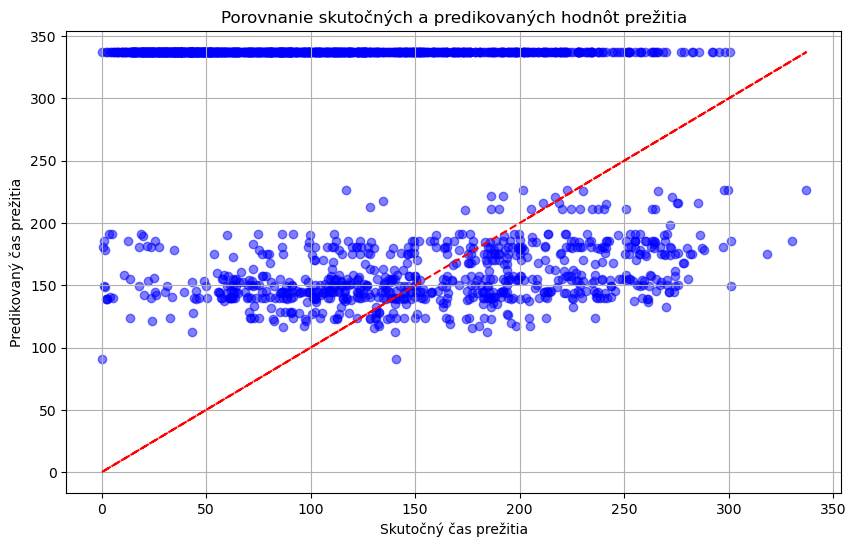

In [87]:
# Získanie skutočných a predikovaných hodnôt prežitia
actual_duration = data_encoded[duration_col]
predicted_duration = cph.predict_expectation(data_encoded)

# Vykreslenie scatter plotu
plt.figure(figsize=(10, 6))
plt.scatter(actual_duration, predicted_duration, color='blue', alpha=0.5)
plt.plot(actual_duration, actual_duration, color='red', linestyle='--')
plt.title('Porovnanie skutočných a predikovaných hodnôt prežitia')
plt.xlabel('Skutočný čas prežitia')
plt.ylabel('Predikovaný čas prežitia')
plt.grid(True)
plt.show()

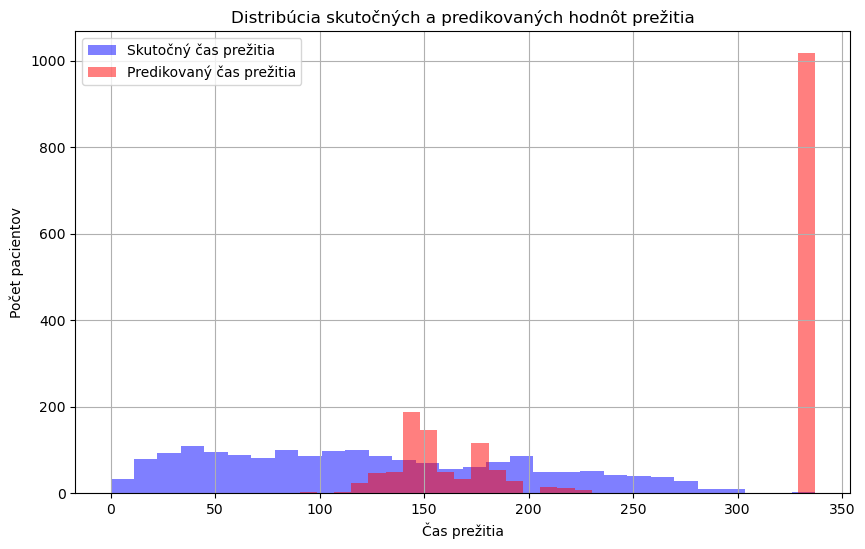

In [89]:
# Získanie skutočných a predikovaných hodnôt prežitia
actual_duration = data_encoded[duration_col]
predicted_duration = cph.predict_expectation(data_encoded)

# Vykreslenie histogramu pre skutočné hodnoty
plt.figure(figsize=(10, 6))
plt.hist(actual_duration, bins=30, color='blue', alpha=0.5, label='Skutočný čas prežitia')

# Vykreslenie histogramu pre predikované hodnoty
plt.hist(predicted_duration, bins=30, color='red', alpha=0.5, label='Predikovaný čas prežitia')

plt.title('Distribúcia skutočných a predikovaných hodnôt prežitia')
plt.xlabel('Čas prežitia')
plt.ylabel('Počet pacientov')
plt.legend()
plt.grid(True)
plt.show()


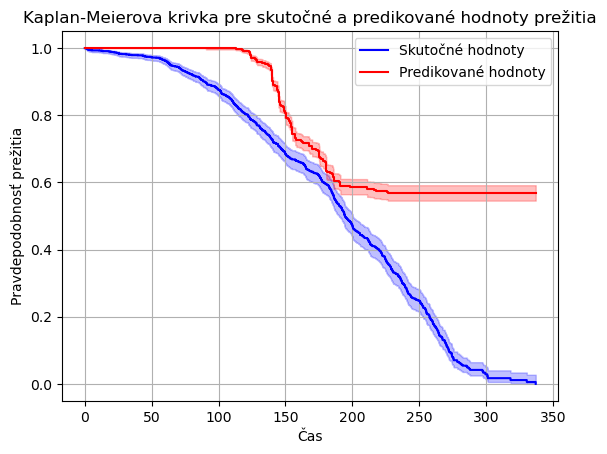

In [90]:
# Vytvorenie Kaplan-Meierovej krivky pre skutočné hodnoty
kmf_actual = KaplanMeierFitter()
kmf_actual.fit(actual_duration, event_observed=data_encoded[event_col])
kmf_actual.plot(color='blue', label='Skutočné hodnoty')

# Vytvorenie Kaplan-Meierovej krivky pre predikované hodnoty
kmf_predicted = KaplanMeierFitter()
kmf_predicted.fit(predicted_duration, event_observed=data_encoded[event_col])
kmf_predicted.plot(color='red', label='Predikované hodnoty')

plt.title('Kaplan-Meierova krivka pre skutočné a predikované hodnoty prežitia')
plt.xlabel('Čas')
plt.ylabel('Pravdepodobnosť prežitia')
plt.legend()
plt.grid(True)
plt.show()

# Random Forest
#### Skúsila som použiť aj tento model, ktorý vo viacerých prách, ktoré sa venovali tejto tématike vykazoval lepšie výsledky ako Coxov model. Vidíme, že model je 100% presný čo ako sa mi neviem či pozdáva :D či je to naozaj tak. Celkovo tu určite vidím potenciál na detailnejšie preskúmanie týchto oblastí, na cenzúrovanie, ktoré je spojené s touto témou, vyhodnocovanie, lepšiu vizualizáciu a porovnanie s metódami strojového učenia. 

Presnosť modelu (Accuracy): 1.0

Klasifikačný report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       210
           1       1.00      1.00      1.00       148

    accuracy                           1.00       358
   macro avg       1.00      1.00      1.00       358
weighted avg       1.00      1.00      1.00       358



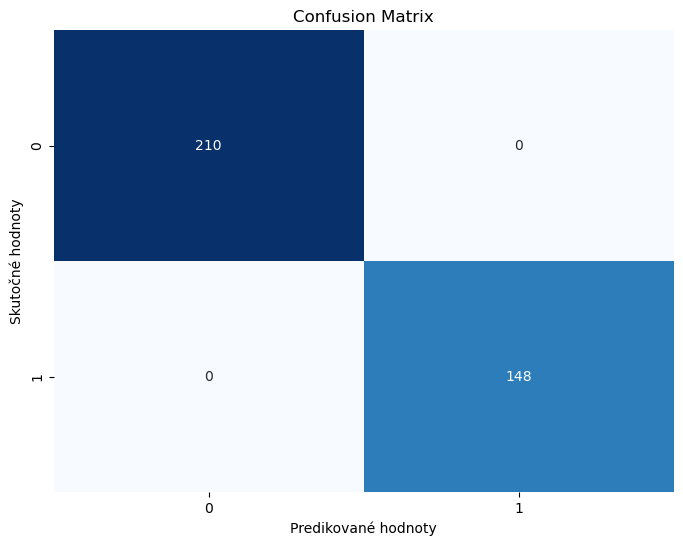

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Rozdelenie dát na trénovaciu a testovaciu sadu
X_train, X_test, y_train, y_test = train_test_split(data_encoded.drop([duration_col, event_col], axis=1), 
                                                    data_encoded[event_col], 
                                                    test_size=0.2, 
                                                    random_state=42)

# Definícia a trénovanie modelu Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predikcia na testovacej sade
y_pred = rf_model.predict(X_test)

# Vyhodnotenie modelu
accuracy = accuracy_score(y_test, y_pred)
print("Presnosť modelu (Accuracy):", accuracy)
print("\nKlasifikačný report:")
print(classification_report(y_test, y_pred))

# Vykreslenie confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predikované hodnoty')
plt.ylabel('Skutočné hodnoty')
plt.title('Confusion Matrix')
plt.show()
